# Learning sampling pattern
Second version of the full algorithm:
- Several images possible
- Learning points or cartesian mask

In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from LowerLevel.pdhg import pdhg

#Upper level imports
from scipy.sparse.linalg import cg,LinearOperator
import scipy
import time
from UpperLevel.LBFGSB import *
from UpperLevel.cost_utils import *

from scipy.stats import norm

In [3]:
import nibabel as nib
import h5py

### Creation of Lower level tools
Creating fourier_op, linear_op and param.

In [4]:
#Size of images to use
n = 50

x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,(n,n))
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=(n,n),implementation='cpu')

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [5]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=1,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"epsilon":1e-2,"gamma":1e-5}

### Initializing upper level
Creating images, kspace_data and updating param

In [6]:
#Oasis image
all_images = [ "oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii"]
              #,"../oasis_data/sub-OAS30278_ses-d1325_run-02_T1w.nii" ]
im = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
im = im.get_fdata()

Nimages = 3
images = [(1+0j)*im[ :, 30:206, i ]for i in range(124,124+Nimages)]

In [7]:
def reduce_img_size( n_dim, image ):
    mid = image.shape[ 0 ] // 2
    f_coef = np.fft.fftshift( np.fft.fft2( image ) )
    reduced_coef = f_coef[ mid - n_dim // 2: mid + n_dim // 2, mid - n_dim // 2: mid + n_dim // 2 ]
    reduced_image = np.fft.ifft2( np.fft.fftshift( reduced_coef ) )
    return np.abs( reduced_image )

images = [reduce_img_size(n,im) for im in images]
kspace_data = [(1+0j)*fourier_op.op(u0_mat)+0.1*np.mean(u0_mat)*np.random.randn(2*n*n).view(np.complex128) 
               for u0_mat in images]

In [8]:
param["c"] = 1e-7
param["beta"] = 3e-1

In [9]:
# -- Main object to learn mask --
# -------------------------------
obj = Mask_Learner(images=images,kspace_data=kspace_data,
                    fourier_op=fourier_op , linear_op=linear_op , param=param , 
                    verbose=-1 , my_const={"sigma":5,"tau":0.1})

# Learning points independantly

In [10]:
p0 = np.random.rand(n**2+1)
p0[-1] = 1e-2
#Choosing beta so that P(p0) = 5 ~ sum(L(û(p),u*))
param["beta"] = 5/np.sum(p0[:-1]*(1-p0[:-1]))

pysap.Image(data=np.reshape(p0[:-1],(n,n))).show()

In [11]:
pf,energy_upper,alphas = obj.optimize(p0=p0)

/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:17: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))



1 iterations: E(p)=327.53203101988703, alpha=0.009353626206396426



2 iterations: E(p)=176.47190985299704, alpha=0.006776776908980683



3 iterations: E(p)=132.26699657826288, alpha=0.005810742077817551



4 iterations: E(p)=85.38497032662667, alpha=0.004466041228692522



5 iterations: E(p)=60.790879456938825, alpha=0.003445793627965568



6 iterations: E(p)=45.94144484924372, alpha=0.0025505161585873707



7 iterations: E(p)=38.22929798384483, alpha=0.0018900951903422776



8 iterations: E(p)=34.28872201136253, alpha=0.0014905516983180216



9 iterations: E(p)=32.39481652333265, alpha=0.0014550573323113879



10 iterations: E(p)=31.521728405159973, alpha=0.001962286409660767



11 iterations: E(p)=31.27703157355612, alpha=0.003489712789621475



12 iterations: E(p)=31.02885695853204, alpha=0.015738803512738854



13 iterations: E(p)=30.981700866126587, alpha=0.039963787625719296



14 iterations: E(p)=30.95428445975359, alpha=0.08613972560748853



15 iterations: E(p)=30.9026725463

377.7073088442783 27.34862380127991


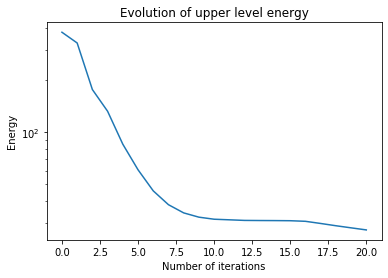

In [12]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/convergence.png")

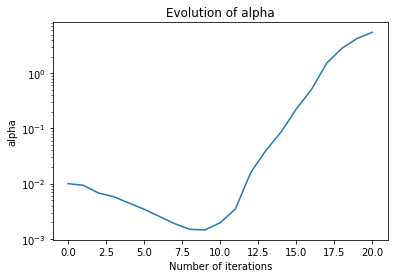

In [13]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

In [14]:
ceiled_pf = np.where(pf>0.5,1,0)
ceiled_pf[-1]=pf[-1]
pysap.Image(data = np.reshape(pf[:-1],(n,n))).show()

In [15]:
print(P(pf,param["beta"]),
E(pk=pf , images=images , kspace_data=kspace_data , fourier_op=fourier_op ,
           linear_op=linear_op , param=param , verbose=-1 , const=obj.const),
np.sum(ceiled_pf))

21.190943750466936 27.34862380127991 1498


In [16]:
mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.96148808786797
Mean ssim ceiled mask:0.9475754788873073


# Learning cartesian mask

In [17]:
l0 = np.random.rand(n+1)
l0[-1] = 5
#Choosing beta so that P(l0) =  ~ sum(L(û(p(l0)),u*))
param["beta"] = 5/np.sum(l0[:-1]*(1-l0[:-1]))

cartesian_p = pcart(l0)
cartesian_p[-1] = l0[-1]

pysap.Image(data=np.reshape(cartesian_p[:-1],(n,n))).show()

In [18]:
lf,energy_upper,alphas = obj.optimize(mask_type = "cartesian" , l0=l0)


1 iterations: E(p)=80.68548001349515, alpha=5.076340637539924



2 iterations: E(p)=52.570991381738324, alpha=5.132106071871425



3 iterations: E(p)=45.44071251373041, alpha=5.165245189867117



4 iterations: E(p)=39.92290855853195, alpha=5.1898497246094815



5 iterations: E(p)=37.88012125128253, alpha=5.205802929635692



6 iterations: E(p)=36.82511760627009, alpha=5.214154189372273



7 iterations: E(p)=36.290212545580324, alpha=5.21598529394012



8 iterations: E(p)=36.039112708010315, alpha=5.214448955237494



9 iterations: E(p)=35.820675939058276, alpha=5.215179022206002



10 iterations: E(p)=35.59310656647989, alpha=5.202878728011836



11 iterations: E(p)=35.36043256919001, alpha=5.208525445713035



12 iterations: E(p)=35.05500659528906, alpha=5.215227658620035



13 iterations: E(p)=34.70217411203393, alpha=5.248183747956811



14 iterations: E(p)=34.48271706898577, alpha=5.283409614874169



FINISHED IN 53.27896547317505 SECONDS



131.09511027798456 34.48271706898577


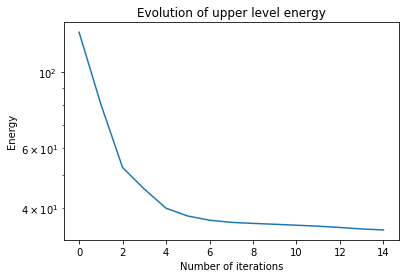

In [19]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/convergence.png")

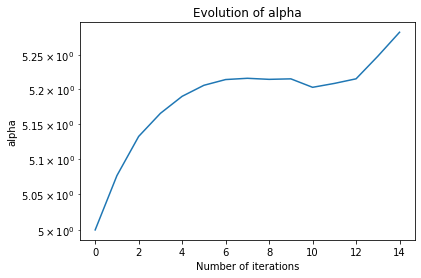

In [20]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

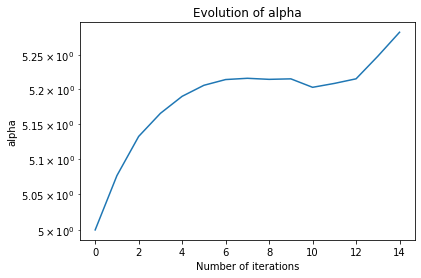

In [21]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

In [22]:
print(lf[-1])
pf = pcart(lf)
ceiled_pf = np.where(pf>0.5,1,0)
pysap.Image(data=np.reshape(pf[:-1],(n,n))).show()

5.283409614874169


In [23]:
print(P(lf,param["beta"]),
E(lk=lf , mask_type = "cartesian" , images=images , kspace_data=kspace_data , fourier_op=fourier_op ,
           linear_op=linear_op , param=param , verbose=-1 , const=obj.const),
np.sum(ceiled_pf))

27.674877407737895 34.48271706898577 2101


In [24]:
mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.9611318161137428
Mean ssim ceiled mask:0.95252938494078
